In [1]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

# Radar processing helper functions

In [4]:
# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, mCalData, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)
    data = data * mCalData
    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, nfft=2**8):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags):
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    max_idxs = max_idxs.astype(int)
    target_idx = int(np.mean(max_idxs))

    return target_idx

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

def find_doppler_bins(f_tags, doppler_freqs):
    search_f = np.concatenate((f_tags, -f_tags))
    bins = []

    for f in search_f: 
        err = np.abs(f - doppler_freqs)
        bins.append(np.argmin(err))

    bins_left = bins[len(f_tags):]
    bins_right = bins[:len(f_tags)]

    return bins_left, bins_right

# Microdisplacement helper functions 

In [5]:
# what does this do? 
def get_period(Igrid, Fgrid, n_frames):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid, range_subset_width, n_frames):
    phi = np.linspace(0, np.pi, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (n_frames, 1))

    period = get_period(Igrid, Qgrid, n_frames)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))

        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos -> why? 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    return unwrapPi(angles)

# Phase values for 0 - 45 degree - 0 file

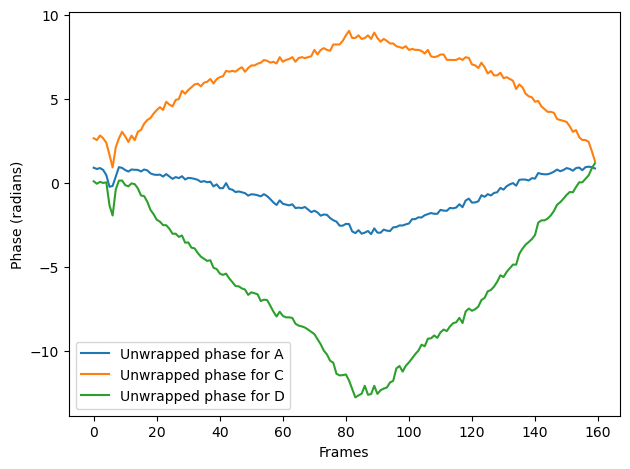

In [6]:
# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 160 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# phase values for each frequency
phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

plt.plot(phaseA, label='Unwrapped phase for A')
# plt.plot(phaseB, label='Unwrapped phase for B')
plt.plot(phaseC, label='Unwrapped phase for C')
plt.plot(phaseD, label='Unwrapped phase for D')

plt.xlabel("Frames")
plt.ylabel("Phase (radians)")
plt.tight_layout()
plt.legend()

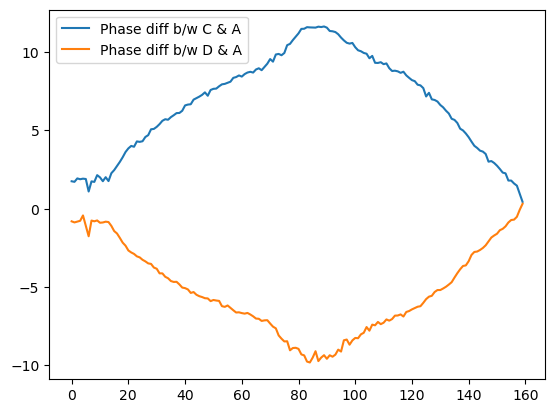

In [ ]:
plt.plot( , label = "Phase diff b/w C & A")
plt.plot(phaseD - phaseA , label = "Phase diff b/w D & A")
plt.legend()phaseC - phaseA

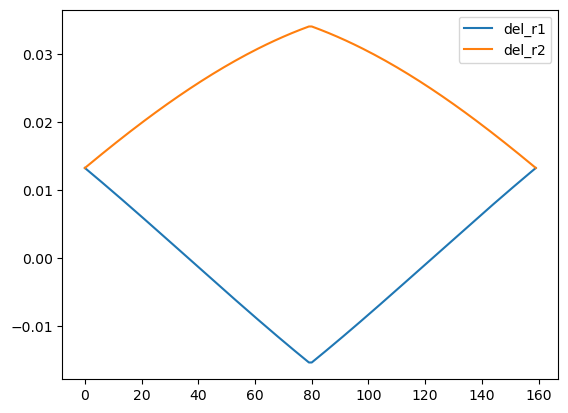

In [18]:
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 
lam = 3e8/24.15e9 

phi0_45 = np.linspace(0, 45, 80)*np.pi/180
phi45_0 = np.linspace(45, 0, 80)*np.pi/180
phis = np.concatenate((phi0_45, phi45_0))
theta = 0 
del_r1s = l*np.sin(alpha - phis + theta)
del_r2s = l*np.sin(alpha + phis - theta)

plt.plot(del_r1s, label='del_r1')
plt.plot(del_r2s, label='del_r2')
plt.legend()

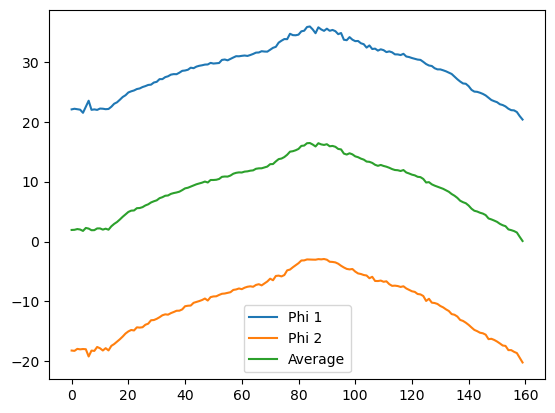

In [25]:
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 
lam = 3e8/24.15e9 
theta = 0 

del_phi1 = phaseD - phaseA
del_phi2 = phaseC - phaseA

del_r1 = (lam / (4*np.pi)) * del_phi1
del_r2 = (lam / (4*np.pi)) * del_phi2

# del_r1 = l sin(alpha - phi + theta) -->  phi = alpha - arcsin(del_r1/l)  [theta = 0]
# del_r2 = l sin(alpha + phi - theta) -->  phi = arcsin(del_r2/l) - alpha  [theta = 0]

phi1 = alpha + theta - np.arcsin(del_r1/l)
phi2 = np.arcsin(del_r2/l) - alpha + theta 

plt.plot(phi1 * 180/np.pi, label="Phi 1")
plt.plot(phi2 * 180/np.pi, label="Phi 2")
plt.plot((phi1+phi2)/2 * (180/np.pi), label="Average")

# plt.plot(del_r1, label='del_r1')
# plt.plot(del_r2, label="del_r2")
# plt.plot(l, label='l')
plt.legend()

Text(0, 0.5, 'Distance (m)')

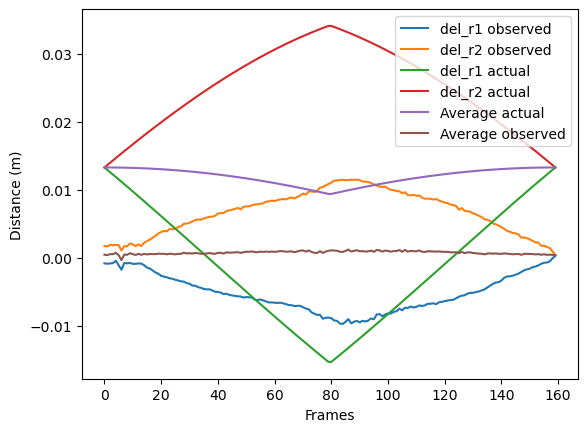

In [30]:
plt.plot(del_r1, label='del_r1 observed')
plt.plot(del_r2, label="del_r2 observed")
plt.plot(del_r1s, label='del_r1 actual')
plt.plot(del_r2s, label='del_r2 actual')
plt.plot((del_r1s + del_r2s)/2, label="Average actual")
plt.plot((del_r1 + del_r2)/2, label="Average observed")
plt.legend()
plt.xlabel("Frames")
plt.ylabel("Distance (m)")

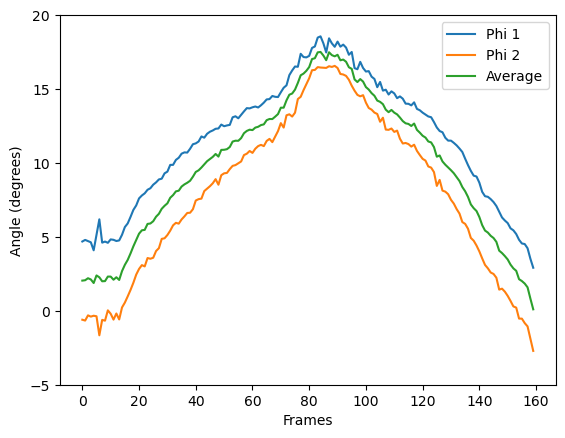

In [ ]:
wrap_shift = np.mean((del_r1s + del_r2s)/2 - (del_r1 + del_r2)/2)

del_r1 = del_r1 + wrap_shift
del_r2 = del_r2 + wrap_shift
phi1 = alpha + theta - np.arcsin(del_r1/l)
phi2 = np.arcsin(del_r2/l) - alpha + theta 

plt.plot(phi1 * 180/np.pi, label="Phi 1")
plt.plot(phi2 * 180/np.pi, label="Phi 2")
plt.plot((phi1+phi2)/2 * (180/np.pi), label="Average")
plt.xlabel("Frames")
plt.ylabel("Angle (degrees)")
plt.ylim(-5, 20)
plt.legend()

Text(0, 0.5, 'Distance (m)')

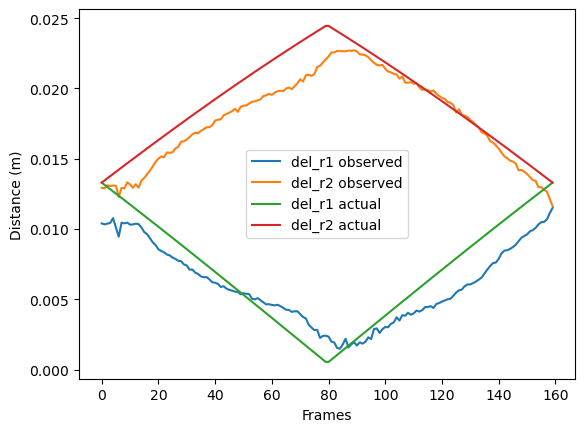

In [39]:
phi0_20 = np.linspace(0, 20, 80)*np.pi/180
phi20_0 = np.linspace(20, 0, 80)*np.pi/180
phis = np.concatenate((phi0_20, phi20_0))
theta = 0 
del_r1_act = l*np.sin(alpha - phis + theta)
del_r2_act = l*np.sin(alpha + phis - theta)
plt.plot(del_r1, label='del_r1 observed')
plt.plot(del_r2, label="del_r2 observed")
plt.plot(del_r1_act, label='del_r1 actual')
plt.plot(del_r2_act, label='del_r2 actual')
# plt.plot((del_r1s + del_r2s)/2, label="Average actual")
# plt.plot((del_r1 + del_r2)/2, label="Average observed")
plt.legend()
plt.xlabel("Frames")
plt.ylabel("Distance (m)")

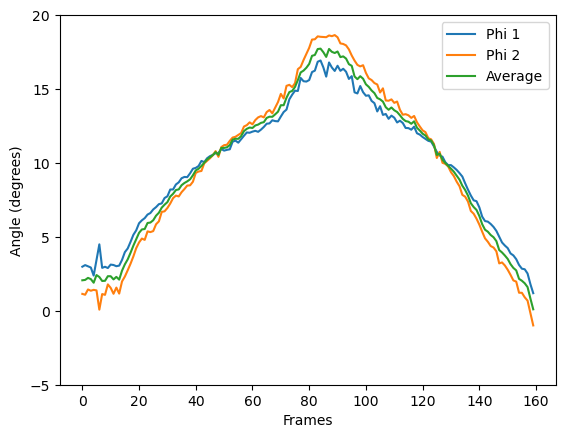

In [40]:
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 
lam = 3e8/24.15e9 
theta = 0 

del_phi1 = phaseD - phaseA
del_phi2 = phaseC - phaseA

del_r1 = (lam / (4*np.pi)) * del_phi1
del_r2 = (lam / (4*np.pi)) * del_phi2
wrap_shift = np.mean((del_r1_act + del_r2_act)/2 - (del_r1 + del_r2)/2)
del_r1 = del_r1 + wrap_shift
del_r2 = del_r2 + wrap_shift
phi1 = alpha + theta - np.arcsin(del_r1/l)
phi2 = np.arcsin(del_r2/l) - alpha + theta 

plt.plot(phi1 * 180/np.pi, label="Phi 1")
plt.plot(phi2 * 180/np.pi, label="Phi 2")
plt.plot((phi1+phi2)/2 * (180/np.pi), label="Average")
plt.xlabel("Frames")
plt.ylabel("Angle (degrees)")
plt.ylim(-5, 20)
plt.legend()

In [37]:
np.max((phi1+phi2)/2 * (180/np.pi))

np.float64(17.509772991771477)

# Implementing steering vector and MUSIC

(3, 80)
[0.0028917  0.00210784 0.00021895]
(3, 80)
[0.00018228 0.0022909  0.00287976]
(3, 80)
[3.00939011e-03 2.04029072e-03 9.43187510e-05]
(3, 80)
[0.0031512  0.0020347  0.00015205]
(3, 80)
[0.00450764 0.00102244 0.00011588]
(3, 80)
[0.00020402 0.00339313 0.00297383]
(3, 80)
[0.00389903 0.00161831 0.00015604]
(3, 80)
[0.0036464  0.00214654 0.00014085]
(3, 80)
[0.0001914  0.00226464 0.00301039]
(3, 80)
[3.23277739e-03 1.66861829e-03 7.96248958e-05]
(3, 80)
[9.72515441e-05 2.38633342e-03 3.17473547e-03]
(3, 80)
[0.00017096 0.00240181 0.00346526]
(3, 80)
[0.00300787 0.00214352 0.00017478]
(3, 80)
[0.00261921 0.00205217 0.00016841]
(3, 80)
[5.48912573e-05 2.51861441e-03 3.17982619e-03]
(3, 80)
[4.38109445e-03 1.74522103e-03 4.73809562e-05]
(3, 80)
[4.41912982e-03 1.41031835e-03 4.92063983e-05]
(3, 80)
[4.60058037e-03 1.60614587e-03 5.15999146e-05]
(3, 80)
[6.47525883e-05 2.24171000e-03 3.60947062e-03]
(3, 80)
[0.00244254 0.00298118 0.00022851]
(3, 80)
[0.00339549 0.00152866 0.00055065]
(

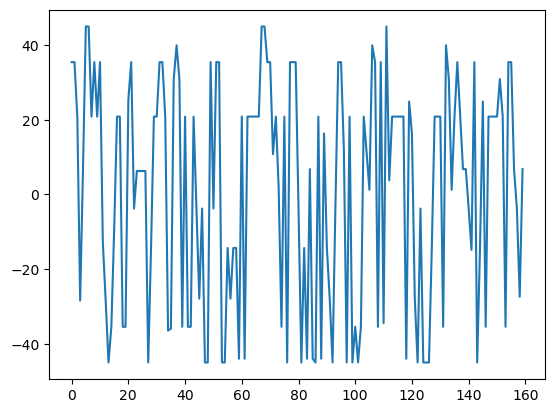

In [ ]:
# Geometry of the tag
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 

theta = 0           # AoA 
phi_deg = np.linspace(-45, 45, 180)        # -45 degrees to 45 degrees, 180 values 
phi_values     = phi_deg/180 * np.pi
                         # lambda

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))

AoA_array = []

for frame_no in range(0, n_frames):
    # let's just use the I_grid for now 

    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # Igrid : #frequencies x #range_subset_bins x #frames 
    
    # MUSIC
    rxn = Igrid[[0,2,3], :, frame_no]       # skipping index 1 (face B) since it is not seen
    print(rxn.shape)
    Rxx = np.cov(rxn)
    [evalues, evectors] = np.linalg.eig(Rxx)
    threshold = 3e-3 # eigenvalue > 1 --> target, o/w noise (empirical)
    print(evalues)
    # n_targets = np.count_nonzero(np.real(evalues) > threshold)
    n_targets = 1
    # n_noise_eigvals = np.count_nonzero(np.real(evalues) < threshold)
    n_noise_eigvals =  3 - n_targets
    evectors_sorted = evectors[:, np.argsort(evalues)]
    Qn = evectors_sorted[0:, 0:n_noise_eigvals]

    results = []

    for phi in phi_values:
        # steering vector for the tag 
        s = np.array([[1,                                                               # 0         (face A)
                       np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha + phi - theta) ),     # del_r2    (face C)
                       np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha - phi + theta) ) ]])  # del_r1    (face D)
    
        phi_music    = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T) 
        phi_music_db = 10*np.log10(np.abs(phi_music))  
        results.append(phi_music_db)

    AOA_idx = np.argmax(np.abs(results))
    AOA = phi_deg[AOA_idx]
    AoA_array.append(AOA)

plt.plot(AoA_array)


In [ ]:
# Geometry of the tag
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 

theta = 0           # AoA 
phi_deg = np.linspace(-45, 45, 180)        # -45 degrees to 45 degrees, 180 values 
phi_values     = phi_deg/180 * np.pi
lam = 3e8/24.15e9                          # lambda

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))

AoA_array = []

for frame_no in range(0, n_frames):
    # let's just use the I_grid for now 

    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))

# Igrid : #frequencies x #range_subset_bins x #frames 

# MUSIC
rxn = Igrid[[0,2,3], range_subset_width//2, :]       # skipping index 1 (face B) since it is not seen
print(rxn.shape)
# Rxx = np.cov(rxn)
# [evalues, evectors] = np.linalg.eig(Rxx)
# threshold = 3e-3 # eigenvalue > 1 --> target, o/w noise (empirical)
# print(evalues)
# # n_targets = np.count_nonzero(np.real(evalues) > threshold)
# n_targets = 1
# # n_noise_eigvals = np.count_nonzero(np.real(evalues) < threshold)
# n_noise_eigvals =  3 - n_targets
# evectors_sorted = evectors[:, np.argsort(evalues)]
# Qn = evectors_sorted[0:, 0:n_noise_eigvals]

# results = []

# for phi in phi_values:
#     # steering vector for the tag 
#     s = np.array([[1,                                                               # 0         (face A)
#                     np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha + phi - theta) ),     # del_r2    (face C)
#                     np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha - phi + theta) ) ]])  # del_r1    (face D)

#     phi_music    = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T) 
#     phi_music_db = 10*np.log10(np.abs(phi_music))  
#     results.append(phi_music_db)

# AOA_idx = np.argmax(np.abs(results))
# AOA = phi_deg[AOA_idx]
# AoA_array.append(AOA)

# plt.plot(AoA_array)


In [ ]:
# Geometry of the tag
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 

theta = 0           # AoA 
phi_deg = np.linspace(-45, 45, 180)        # -45 degrees to 45 degrees, 180 values 
phi_values     = phi_deg/180 * np.pi       # radian
lam = 3e8/24.15e9                          # lambda

# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_15-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 50 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))


# rxn : #frequencies x #frames
rxn = Igrid[[0,2,3], range_subset_width//2, :]       # skipping index 1 (face B) since it is not seen
print(rxn.shape)
Rxx = np.cov(rxn)
[evalues, evectors] = np.linalg.eig(Rxx)
n_targets = 1
n_noise_eigvals =  3 - n_targets
evectors_sorted = evectors[:, np.argsort(evalues)]
Qn = evectors_sorted[0:, 0:n_noise_eigvals]

for phi in phi_values:
    # steering vector for the tag 
    s = np.array([[np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha + phi - theta) ),      # del_r2 (face A)
                   np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha - phi + theta) ),    # del_r1 (face C)
                   1]])                                                            # 0    (face D)

    phi_music    = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T) 
    phi_music_db = 10*np.log10(np.abs(phi_music))  
    results.append(phi_music_db)

AOA_idx = np.argmax(np.abs(results))
AOA = phi_deg[AOA_idx]
print(AOA)

(3, 50)
6.787709497206706


In [ ]:
# Geometry of the tag
l = 37.38e-3        # 37.38 mm
alpha = 0.3638      # ~ 20 degrees 

theta = 0           # AoA 
phi_deg = np.linspace(-45, 45, 180)        # -45 degrees to 45 degrees, 180 values 
phi_values     = phi_deg/180 * np.pi       # radian
lam = 3e8/24.15e9                          # lambda

# %matplotlib ipympl
data = pickle.load(open('/nas-data/soham/drone-landing/test_2cm_diagonal_0-24GHz.pickle', 'rb'))
data_raw = data['Data']

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
f_tags = np.array([183, 337, 250, 127])
# f_tags = np.array([156, 250, 313, 625])

cfg = data['Cfg']
CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

# Calibration calculations
# -- N: number of samples (256)
# -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
mCalData = np.transpose(rep, (2, 1, 0))

n_frames = 50 

range_subset_width = 80 
doppler_max = (8.69*255)/2
doppler_min = -doppler_max 
doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
num_rx = 4
num_tx = 1

Igrid = np.zeros((4, range_subset_width, n_frames))
Qgrid = np.zeros((4, range_subset_width, n_frames))
Pgrid = np.zeros((4, range_subset_width, n_frames))
dopgrid = np.zeros((nfft, num_rx))

side1 = 1
side2 = 3
side3 = 2
side4 = 0        

# side1 = 0
# side2 = 1
# side3 = 2
# side4 = 3

binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

mbl = [0,0,0,0]
mbr = [0,0,0,0]
mbl[0] = binsleft[side1]
mbr[0] = binsright[side1]
mbl[1] = binsleft[side2]
mbr[1] = binsright[side2]
mbl[2] = binsleft[side3]
mbr[2] = binsright[side3]
mbl[3] = binsleft[side4]
mbr[3] = binsright[side4]

# Do all this for a single frame
for frame_no in range(0, n_frames):
    frame = data_raw[:, frame_no ,:]
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
    RD = get_RD(RP)        # 256 x 256 x 4 

    range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

    # take for only one antenna for now 
    RD = RD[:, :, antenna_pick]

    for i in range(len(f_tags)):
        # Take the range subset for all angles 
        RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
        RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
        
        I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
        Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

        # Take the phase across the range subset 
        phase = np.atan(I_tag/Q_tag) 

        Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
        Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
        Pgrid[i][:, frame_no] = normalize(np.abs(phase))


# rxn : #frequencies x #frames
rxn = Igrid[[0,2,3], range_subset_width//2, :]       # skipping index 1 (face B) since it is not seen
print(rxn.shape)
Rxx = np.cov(rxn)
[evalues, evectors] = np.linalg.eig(Rxx)
n_targets = 1
n_noise_eigvals =  3 - n_targets
evectors_sorted = evectors[:, np.argsort(evalues)]
Qn = evectors_sorted[0:, 0:n_noise_eigvals]

results = []

for phi in phi_values:
    # steering vector for the tag 
    s = np.array([[np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha + phi - theta) ),    # del_r2 (face A)
                   np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha - phi + theta) ),    # del_r1 (face C)
                   1]])                                                            # 0    (face D)

    phi_music    = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T) 
    phi_music_db = 10*np.log10(np.abs(phi_music))  
    results.append(phi_music_db)

AOA_idx = np.argmax(np.abs(results))
AOA = phi_deg[AOA_idx]
print(AOA)

(3, 50)
4.273743016759781


In [ ]:
def plot_aoa(filename):
    # Geometry of the tag
    l = 37.38e-3        # 37.38 mm
    alpha = 0.3638      # ~ 20 degrees 

    theta = 0           # AoA 
    phi_deg = np.linspace(-45, 45, 180)        # -45 degrees to 45 degrees, 180 values 
    phi_values     = phi_deg/180 * np.pi       # radian
    lam = 3e8/24.15e9                          # lambda

    # %matplotlib ipympl
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']      # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    n_frames = 20-10 #89 

    range_subset_width = 80 
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((4, range_subset_width, n_frames))
    Qgrid = np.zeros((4, range_subset_width, n_frames))
    Pgrid = np.zeros((4, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    side1 = 1
    side2 = 3
    side3 = 2
    side4 = 0        

    # side1 = 0
    # side2 = 1
    # side3 = 2
    # side4 = 3

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    # Do all this for a single frame
    for frame_no in range(30, 40):
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)

        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]   
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no-30] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no-30] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no-30] = normalize(np.abs(phase))


    # rxn : #frequencies x #frames
    rxn = Igrid[[0,2,3], range_subset_width//2, :]       # skipping index 1 (face B) since it is not seen
    Rxx = np.cov(rxn)
    [evalues, evectors] = np.linalg.eig(Rxx)
    n_targets = 1
    n_noise_eigvals =  3 - n_targets
    evectors_sorted = evectors[:, np.argsort(evalues)]
    Qn = evectors_sorted[0:, 0:n_noise_eigvals]

    results = []

    for phi in phi_values:
        # steering vector for the tag 
        s = np.array([[np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha + phi - theta) ),    # del_r2 (face A)
                    np.exp( -1j * (4*np.pi*l/lam)*np.sin(alpha - phi + theta) ),    # del_r1 (face C)
                    1]])                                                            # 0    (face D)

        phi_music    = 1 / (s.conj() @ Qn @ Qn.conj().T @ s.T) 
        phi_music_db = 10*np.log10(np.abs(phi_music))  
        results.append(phi_music_db)

    results = np.array(results)
    results = results.reshape((results.shape[0],))
    plt.plot(results)
    AOA_idx = np.argmax(np.abs(results))
    AOA = phi_deg[AOA_idx]
    return AOA

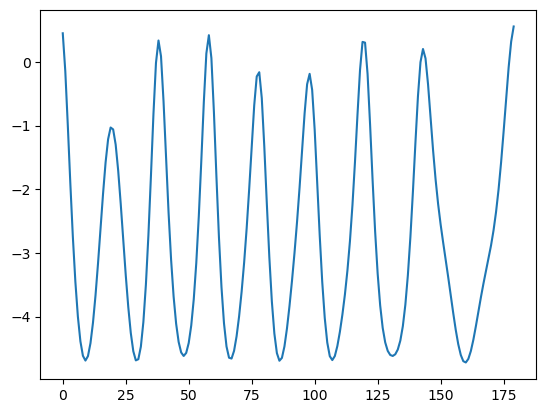

In [ ]:
filename = f"/nas-data/soham/drone-landing/test_2cm_diagonal_15-24GHz.pickle"
_ =  plot_aoa(filename)

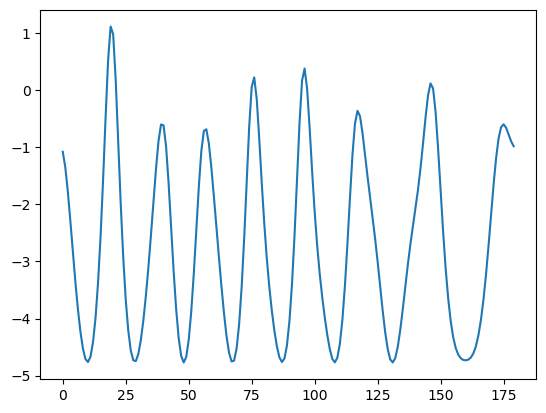

In [103]:
filename = f"/nas-data/soham/drone-landing/test_2cm_diagonal_45-24GHz.pickle"
_ =  plot_aoa(filename)

(3, 10)
(3, 10)
(3, 10)
(3, 10)


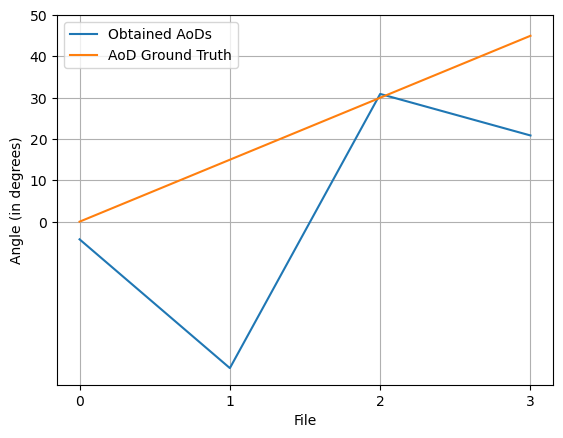

In [ ]:
AoA_array = []
AoA_gt = np.array([0, 15, 30, 45])
for AoA in AoA_gt:
    filename = f"/nas-data/soham/drone-landing/test_2cm_diagonal_{AoA}-24GHz.pickle"
    AoA_array.append(plot_aoa(filename))

plt.plot(-np.array(AoA_array), label='Obtained AoDs')
plt.plot(AoA_gt, label="AoD Ground Truth")
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 10, 20, 30, 40, 50])
plt.xlabel("File")
plt.ylabel("Angle (in degrees)")
plt.legend()
plt.grid()

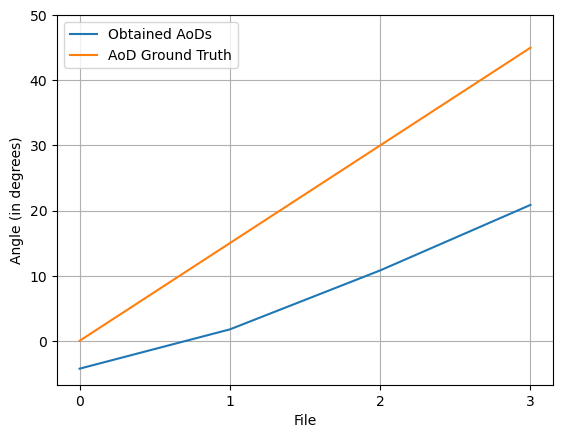

(3, 10)
[array([[0.45138644]]), array([[-0.14253832]]), array([[-0.99636036]]), array([[-1.90675355]]), array([[-2.74601348]]), array([[-3.45238104]]), array([[-4.00201618]]), array([[-4.38944299]]), array([[-4.6174003]]), array([[-4.69231339]]), array([[-4.62268149]]), array([[-4.41900555]]), array([[-4.09466488]]), array([[-3.66753593]]), array([[-3.16226774]]), array([[-2.6129773]]), array([[-2.06555492]]), array([[-1.57765046]]), array([[-1.2132487]]), array([[-1.02956754]]), array([[-1.05928278]]), array([[-1.2980967]]), array([[-1.70681571]]), array([[-2.22592708]]), array([[-2.79209181]]), array([[-3.34866131]]), array([[-3.84936111]]), array([[-4.25782469]]), array([[-4.54554548]]), array([[-4.68966664]]), array([[-4.67122044]]), array([[-4.47415163]]), array([[-4.08562592]]), array([[-3.49880691]]), array([[-2.72082706]]), array([[-1.79131969]]), array([[-0.81762612]]), array([[-0.01381442]]), array([[0.33774611]]), array([[0.08961711]]), array([[-0.61669044]]), array([[-1.504

ValueError: x and y can be no greater than 2D, but have shapes (180,) and (180, 1, 1)

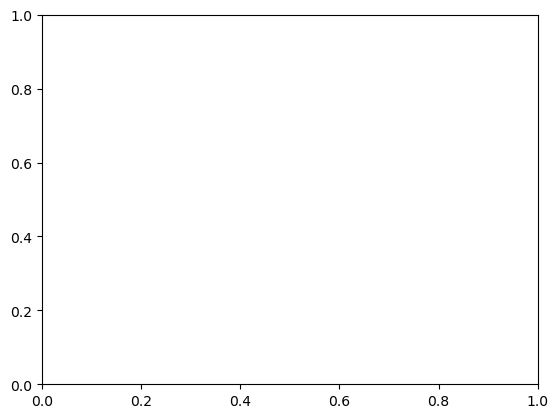

In [104]:
lam/l

0.33232638438863576

In [106]:
d_max = lam / (1 + np.sin(np.pi/4))
d_max

np.float64(0.007276850156855962)

In [107]:
d_max/lam

np.float64(0.585786437626905)